## Project details

The purpose of this project to do binary classification using MobileNet as base model for transfert learning.

The dataset we'll use is the [Alpaca/Not alpaca](https://www.kaggle.com/datasets/sid4sal/alpaca-dataset-small) dataset available on kaggle.

## Packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import os

## Load Dataset and Split it into Training and Validation Sets

To load image files stored on disk we'll use `image_data_set_from_directory()` to read from the directory and create both training and validation datasets (`tf.data.Dataset` format). 

As we'll be using a validation split, in order to split the data, we need to specify the subset for each portion: `subset='training'` for training set and `subset='validation'` for validation set.

The `seed` state ensure reproduction. 

In [2]:
DATASET_DIR = 'dataset'
batch_size = 32
image_size = (160, 160)

training_dataset = image_dataset_from_directory(DATASET_DIR,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                validation_split=0.2,
                                                subset='training',
                                                seed=42)

validation_dataset = image_dataset_from_directory(DATASET_DIR,
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images in the dataset

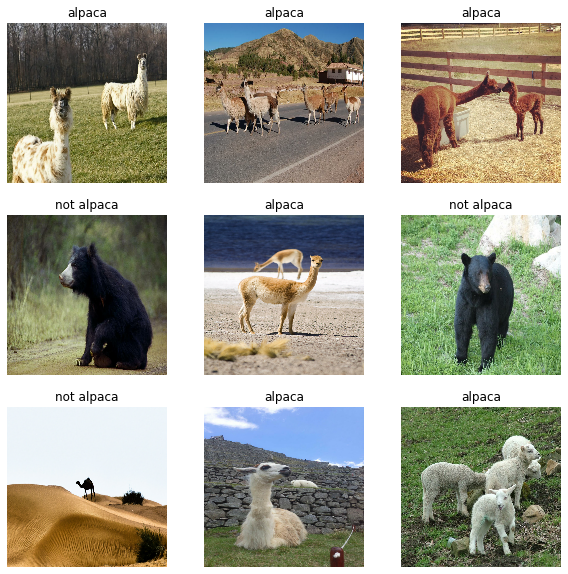

In [3]:
class_names = training_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
    for i in range(9):        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

## Preprocess and augment data


We will use `prefetch()` to prevent a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

We will use `prefetch()` method require `buffer_size`as input. You can set an arbitrary number or use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)

Let's define some basic image augmentation model

In [5]:
def data_augmenter():
    data_agmentation = tf.keras.Sequential()
    data_agmentation.add(RandomFlip('horizontal'))
    data_agmentation.add(RandomRotation(0.2))
    
    return data_agmentation

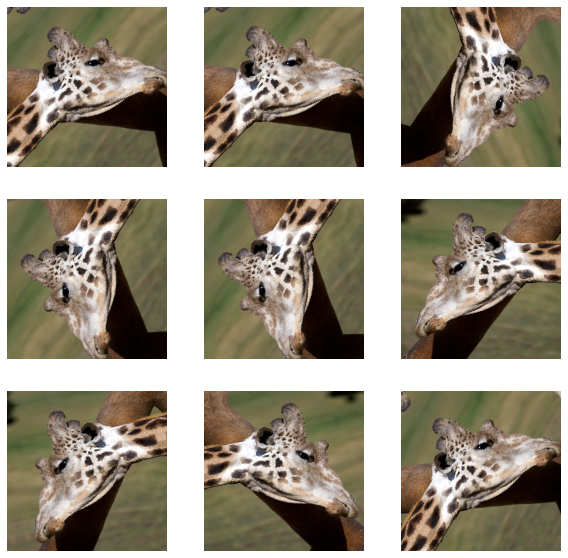

In [6]:
data_augmentation = data_augmenter()

for image, _ in training_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

As we plan to do transfer learning with MobileNet as base model, we need to normalize input images accordingly. Since the pre-trained model was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create model and train it

In [8]:
input_shape = image_size + (3,)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model by making it non trainable
base_model.trainable = False

# create the input layer (Same as the imageNetv2 input size)
inputs = tf.keras.Input(shape = input_shape) 

# apply data augmentation to the inputs
x = data_augmentation(inputs)

# data preprocessing using the same weights the model was trained on
x = preprocess_input(x)

# set training to False to avoid keeping track of statistics in the batch norm layer
x = base_model(x, training = False)

# Add the new Binary classification layers
# use global avg pooling to summarize the info in each channel
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#include dropout with probability of 0.2 to avoid overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# create a prediction layer with one neuron (as a classifier only needs one)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model = tf.keras.Model(inputs, outputs)

model.summary()

base_learning_rate = 1e-3 # Defalut learning rate for Adam optimizer in Keras

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [9]:
initial_epochs = 5
batch_size = 32
history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                   epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 11s 766ms/step - loss: 0.7201 - accuracy: 0.5344 - val_loss: 0.6122 - val_accuracy: 0.5231
Epoch 2/5
9/9 [==============================] - 6s 604ms/step - loss: 0.5933 - accuracy: 0.6641 - val_loss: 0.4528 - val_accuracy: 0.7385
Epoch 3/5
9/9 [==============================] - 7s 651ms/step - loss: 0.5294 - accuracy: 0.7176 - val_loss: 0.4078 - val_accuracy: 0.6615
Epoch 4/5
9/9 [==============================] - 6s 557ms/step - loss: 0.4220 - accuracy: 0.7939 - val_loss: 0.3614 - val_accuracy: 0.6923
Epoch 5/5
9/9 [==============================] - 7s 643ms/step - loss: 0.4106 - accuracy: 0.7672 - val_loss: 0.3373 - val_accuracy: 0.7538


plot the training and validation accuracy

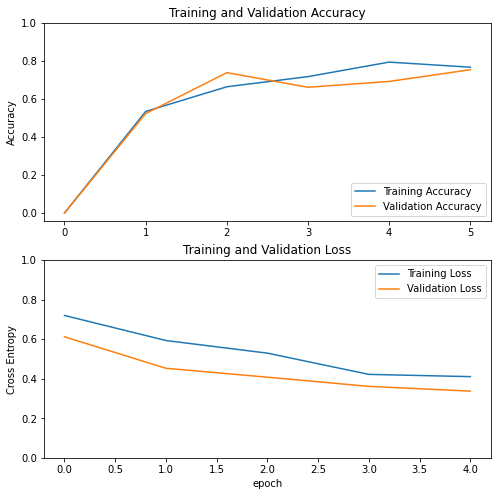

In [10]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As we can see, the model gives pretty descent performances. Let's try some fine tunning to improve it further

## Model fine tunning

To fine-tune our model, we'll unfreeze some layers at the end of the base model and re-training our model on the final layers with a very low learning rate. Adapting the learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

In [11]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)

# Use accuracy as evaluation metric
metrics = ['accuracy']

learning_rate= 1e-4 #0.1 * base_learning_rate

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

Number of layers in the base model:  154


Re-train the model

In [12]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(training_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 12s 840ms/step - loss: 0.3977 - accuracy: 0.7977 - val_loss: 0.2795 - val_accuracy: 0.9077
Epoch 6/10
9/9 [==============================] - 8s 730ms/step - loss: 0.4022 - accuracy: 0.8092 - val_loss: 0.2071 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 8s 758ms/step - loss: 0.3195 - accuracy: 0.8473 - val_loss: 0.2005 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 9s 922ms/step - loss: 0.2085 - accuracy: 0.8969 - val_loss: 0.1077 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 9s 958ms/step - loss: 0.1279 - accuracy: 0.9466 - val_loss: 0.0821 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 9s 860ms/step - loss: 0.1526 - accuracy: 0.9427 - val_loss: 0.0431 - val_accuracy: 1.0000


In [13]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

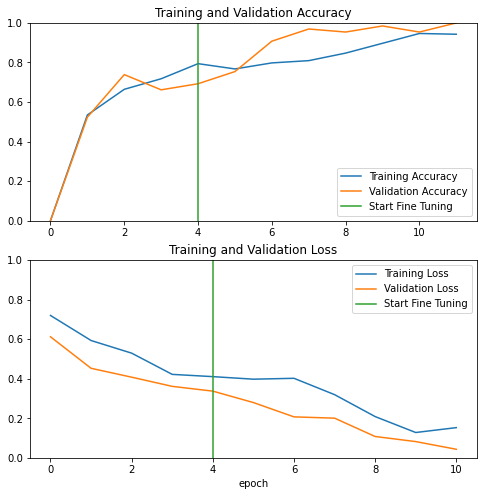

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Callbacks

As can be seen, the fine-tunning process significantly imporves our model performance. To even do better, one can train longer and in that case, to ensure that the model does not train for more epochs than necessary, we have to implement callbacks for early stopping. 

We will also implement callbacks for model checkpoint in order to save the best model when found. This allows to resume the training from the best weights for exemple when the kernel crashes due to unexpected circumstances.

### Early Stopping

We will monitor `val_loss` and as soon as there are no further improvements i.e. it can’t be minimized further, training is stopped.

In [15]:
early_stooping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #metric to monitor
    mode='min', # whether to min or max the metric monitored
    patience=5,  # epochs to wait before declaring stopped training
    verbose=1, # output epoch when training was stopped
)

### Model checkpoint

Here we will also monitor `val_loss` and save the best model from all epochs.

In [16]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_fine_tuned_model.h5',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

### Retrain the model

In [17]:
fine_tune_epochs = 20
total_fine_tuned_epochs =  total_epochs + fine_tune_epochs

history_total_fine = model.fit(training_dataset,
                               epochs=total_fine_tuned_epochs,
                               initial_epoch=history_fine.epoch[-1],
                               validation_data=validation_dataset,
                               callbacks=[early_stooping, model_checkpoint]                             
                              )

Epoch 10/30
9/9 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9771
Epoch 00010: val_loss improved from inf to 0.05440, saving model to best_fine_tuned_model.h5


C:\Users\silve\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


9/9 [==============================] - 9s 887ms/step - loss: 0.0811 - accuracy: 0.9771 - val_loss: 0.0544 - val_accuracy: 0.9692
Epoch 11/30
9/9 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9580
Epoch 00011: val_loss did not improve from 0.05440
9/9 [==============================] - 8s 738ms/step - loss: 0.0895 - accuracy: 0.9580 - val_loss: 0.0803 - val_accuracy: 0.9538
Epoch 12/30
9/9 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9466
Epoch 00012: val_loss improved from 0.05440 to 0.04333, saving model to best_fine_tuned_model.h5
9/9 [==============================] - 9s 899ms/step - loss: 0.1313 - accuracy: 0.9466 - val_loss: 0.0433 - val_accuracy: 1.0000
Epoch 13/30
9/9 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9656
Epoch 00013: val_loss did not improve from 0.04333
9/9 [==============================] - 8s 730ms/step - loss: 0.0804 - accuracy: 0.9656 - val_loss: 0.0445 - val_accuracy: 0.9692
Epoch 

In [18]:
acc += history_total_fine.history['accuracy']
val_acc += history_total_fine.history['val_accuracy']

loss += history_total_fine.history['loss']
val_loss += history_total_fine.history['val_loss']

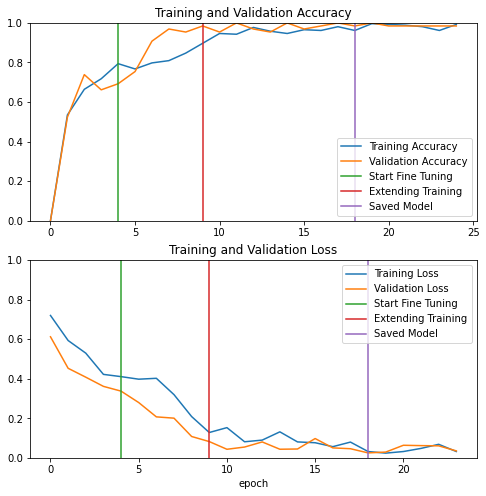

In [20]:
# Manually set epoch value of the saved model (see in the training history above)
saved_model_epoch = 17

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([total_epochs-1,total_epochs-1],
          plt.ylim(), label='Extending Training')
plt.legend(loc='lower right')
plt.plot([saved_model_epoch+1,saved_model_epoch+1],
          plt.ylim(), label='Saved Model')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([total_epochs-1,total_epochs-1],
          plt.ylim(), label='Extending Training')
plt.plot([saved_model_epoch+1,saved_model_epoch+1],
          plt.ylim(), label='Saved Model')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()